# Libraries

##  Remove warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Tensorflow library
#
import tensorflow 
from   tensorflow.keras.metrics                 import *
from   tensorflow.keras.optimizers              import *
from   tensorflow.keras.callbacks               import EarlyStopping
from   tensorflow.keras.callbacks               import ModelCheckpoint
from   tensorflow.keras.callbacks               import ReduceLROnPlateau


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.PerformanceMetrics import RegressionEvaluation
from utils.plot_scatter       import *

# Parameters

## CUDA

In [3]:
try:
    gpus = tensorflow.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tensorflow.config.experimental.set_memory_growth(gpu, True)

            logical_gpus = tensorflow.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

        except RuntimeError as e:

            # Memory growth must be set before GPUs have been initialized
            print(e)
except:
    print('[INFO] Not GPU found')

## Neural networks parameters

In [4]:
Lag        =   12
Horizon    =   4
#
epochs     =  200
batch_size =   16

## Data handling parameters

In [5]:
# Parameters
#
filename   = '../metadata/7-kanal-1.csv'

Transformation  = True
Scaling         = 'Standard'

# Data handling

## Import data


In [6]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.34 seconds


,Date,Temperature,Humidity,PM2.5,PM10,NO2,CO
0,2022-02-19 00:00:09,-2.4,86.0,2.7,4.9,212.0,263.0
1,2022-02-19 00:00:25,-2.4,86.0,2.7,7.6,209.0,261.0
2,2022-02-19 00:00:41,-2.4,86.0,2.6,7.3,204.0,258.0


## Preprocess data

### Set index

In [7]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


df = df.resample('5min').mean().interpolate()
# df = pd.DataFrame( df[ ['CO'] ] )
df = pd.DataFrame( df[ ['NO2', 'CO'] ] )
# df = pd.DataFrame( df[ ['Temperature', 'Humidity', 'NO2', 'CO'] ] )


df.head(3)

,NO2,CO
Date,,
2022-02-19 00:00:00,186.210526,248.947368
2022-02-19 00:05:00,151.052632,232.473684
2022-02-19 00:10:00,135.315789,226.947368


In [8]:
targetSeries = df.columns[-1]

### Split Training/Testing

In [9]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ].dropna()
df_test  = df[ idx: ].dropna()

### Visualization

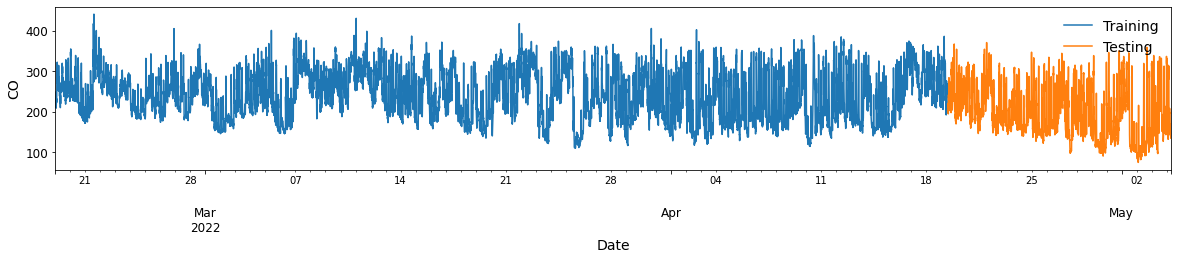

In [10]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 3) )

df_train[targetSeries].plot(ax=ax, color='tab:blue' )
df_test[targetSeries].plot(ax=ax,  color='tab:orange')

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.ylabel(targetSeries, size = 14)
plt.xlabel('Date', size = 14);
plt.xticks(size = 12);
plt.yticks(size = 12);

### Fixing Lag

In [11]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Preprocessing

## Data Transformation

In [12]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    VALUE = np.ceil( max(abs( -df.min().min() ), 1.0) )
    
    df_train = np.log( df_train + VALUE)
    df_test  = np.log( df_test  + VALUE)
    
else:
    print('[INFO] No data transformation applied.')  

[INFO] Data transformation applied


In [13]:
if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    for feature in df.columns:
        if (feature == targetSeries): continue
        print('Feature: ', feature)        
        # Set scaler
        #
        scaler = MinMaxScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = MinMaxScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
            
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    for feature in df.columns:
        if (feature == targetSeries): continue
        print('Feature: ', feature)        
        # Set scaler
        #
        scaler = RobustScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = RobustScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')

    for feature in df.columns:
        if (feature == targetSeries): continue
        print('Feature: ', feature)
        # Set scaler
        #
        scaler = StandardScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )             
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   
    
    for feature in df.columns:
        if (feature == targetSeries): continue
        print('Feature: ', feature)
        # Set scaler
        #
        scaler = StandardScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )  

[INFO] Scaling: Standard
Feature:  NO2


### Include date/time features

In [14]:
# df_train['Time (sin)'] = np.sin( df_train.index.hour + df_train.index.minute / 60 )
# df_train['Time (cos)'] = np.cos( df_train.index.hour + df_train.index.minute / 60 )
# #
# df_test['Time (sin)']  = np.sin( df_test.index.hour + df_test.index.minute / 60 )
# df_test['Time (cos)']  = np.cos( df_test.index.hour + df_test.index.minute / 60 )

## Create Training/Testing data

In [15]:
def create_dataset(df = None, Lag = 1, Horizon = 12, targetSeries = None, overlap = 1):
    
    if (targetSeries is None):
        targetSeries = df.columns[-1]
    
    dataX, dataY = [], []
    
    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon, overlap) ):
        
        dataX.append( df.to_numpy()[i:(i+Lag)] )        
        dataY.append( df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon] )
        
        
    return ( np.array(dataX), np.array(dataY) )


In [16]:
trainX, trainY = create_dataset(df           = df_train, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries,
                                overlap      = Horizon,)
                               

testX,  testY  = create_dataset(df           = df_test, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries,
                                overlap      = 1,)


print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4277/4277 [00:00<00:00, 110416.50it/s]

Training instances:     4276
Testing instances:      4277


In [17]:
trainX.shape, trainY.shape

((4276, 12, 2), (4276, 4))

# Forecasting model: NBeats

In [18]:
import random, os
seed = 42
    
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tensorflow.random.set_seed(seed)

## Setup model

In [19]:
from utils.NBeats_Keras import NBeatsNet

model = NBeatsNet(stack_types         = (NBeatsNet.SEASONALITY_BLOCK, NBeatsNet.TREND_BLOCK),
                  forecast_length     = Horizon,
                  input_dim           = trainX.shape[2],
                  backcast_length     = trainX.shape[1],
                  hidden_layer_units  = 256, 
                  activation_function = 'relu')

2022-05-11 13:11:18.463445: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training parameters

In [20]:
# Define metrics
#
metrics = [
            MeanAbsoluteError(name = "MAE", dtype = None),
            RootMeanSquaredError(name = 'RMSE', dtype = None),
          ]

model.compile(loss = 'mse', optimizer = Adam(learning_rate = 5.e-4), metrics = metrics)
# 

In [21]:
# Checkpoint
#
checkpoint = ModelCheckpoint("models/NBeats.hdf5", 
                              monitor        = 'val_loss', 
                              verbose        = 0, 
                              save_best_only = True, 
                              mode           = 'min')

# Earlystopping
earlystopping = EarlyStopping(monitor       = 'val_loss', 
                              mode          = 'min', 
                              verbose       = 1, 
                              patience      = 10)

# Learning rate adjustment
#
lrs_scheduler  = ReduceLROnPlateau(monitor     = 'val_loss', 
                                   factor      = 0.5,
                                   patience    = 5)

## Training process

In [22]:
# Start clock
#
start = time.time()


score = model.fit(trainX, trainY,                   
                  epochs          = epochs, 
                  batch_size      = batch_size, 
                  callbacks       = [checkpoint, earlystopping, lrs_scheduler],
                  shuffle         = True,
                  verbose         = 1, 
                  validation_data = (testX, testY))


# Terminate clock
#
stop = time.time()
print('[INFO] Time %.2f' % (stop - start))

Epoch 1/200
268/268 [==============================] - 6s 12ms/step - loss: 0.2039 - MAE: 0.3079 - RMSE: 0.4516 - val_loss: 0.3448 - val_MAE: 0.3905 - val_RMSE: 0.5872 - lr: 5.0000e-04
Epoch 2/200
268/268 [==============================] - 3s 10ms/step - loss: 0.1811 - MAE: 0.2880 - RMSE: 0.4256 - val_loss: 0.3390 - val_MAE: 0.3809 - val_RMSE: 0.5822 - lr: 5.0000e-04
Epoch 3/200
268/268 [==============================] - 3s 10ms/step - loss: 0.1787 - MAE: 0.2841 - RMSE: 0.4227 - val_loss: 0.3433 - val_MAE: 0.4175 - val_RMSE: 0.5860 - lr: 5.0000e-04
Epoch 4/200
268/268 [==============================] - 3s 10ms/step - loss: 0.1747 - MAE: 0.2804 - RMSE: 0.4179 - val_loss: 0.3172 - val_MAE: 0.3724 - val_RMSE: 0.5632 - lr: 5.0000e-04
Epoch 5/200
268/268 [==============================] - 2s 9ms/step - loss: 0.1730 - MAE: 0.2777 - RMSE: 0.4159 - val_loss: 0.3247 - val_MAE: 0.3720 - val_RMSE: 0.5698 - lr: 5.0000e-04
Epoch 6/200
268/268 [==============================] - 2s 9ms/step - loss: 0

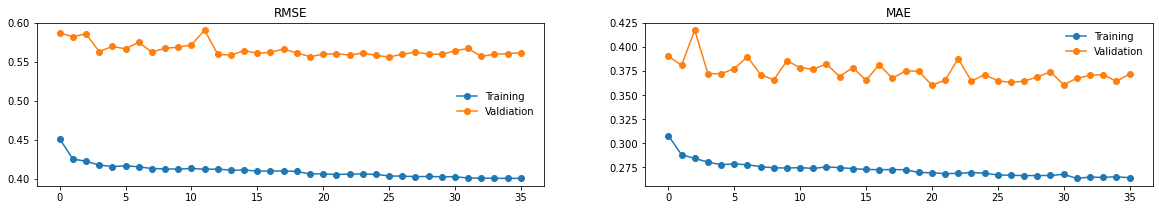

In [23]:
# Create figure
#
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 3) )

# Plot RMSE
#
ax[0].plot( score.history['RMSE'], marker = 'o');
ax[0].plot( score.history['val_RMSE'], marker = 'o');
ax[0].legend(['Training', 'Valdiation'], frameon = False);
ax[0].set_title('RMSE');

# Plot RMSE
#
ax[1].plot( score.history['MAE'], marker = 'o');
ax[1].plot( score.history['val_MAE'], marker = 'o');
ax[1].legend(['Training', 'Validation'], frameon = False);
ax[1].set_title('MAE');

## Load optimized model

In [24]:
# Load the best model
#
model.load_weights('models/NBeats.hdf5')

print('[INFO] Model loaded')

[INFO] Model loaded


## Evaluation

### Get predictions

In [25]:
# Get predictions
#
pred = model.predict( testX ).squeeze(-1)

In [26]:
testY.shape, pred.shape

((4277, 4), (4277, 4))

### Apply inverse scaling/transformation

In [27]:
# Apply inverse scaling
#
for i in range( Horizon ):
    testY[:,  i] = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (Transformation == True):
    testY = np.exp( testY ) - VALUE
    pred  = np.exp( pred )  - VALUE

### Calculate Performance on Testing set - Prediction visualization


In [28]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices[targetSeries] = testY[:,i]
    Prices['Prediction'] = pred[:,i]


    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]

    # Present results
    #
#     print('Horizon: ', i+1)
#     print('> MAE:   ', MAE)
#     print('> RMSE:  ', RMSE)
#     print('> SMAPE: ', SMAPE)
#     print('> R2:    ', R2)
#     print()
    
    print('Horizon: %2i MAE %5.2f SMAPE: %5.2f R2: %.2f' % (i+1, MAE, SMAPE, R2) )

[INFO] Feature:  CO
------------------------------------------------
Horizon:  1 MAE  9.69 SMAPE:  4.73 R2: 0.94
Horizon:  2 MAE 17.36 SMAPE:  8.47 R2: 0.81
Horizon:  3 MAE 22.57 SMAPE: 11.14 R2: 0.71
Horizon:  4 MAE 26.59 SMAPE: 13.15 R2: 0.61


In [29]:
# CO - Log+StandardScaler
# ------------------------------------------------
# Horizon:  1 MAE  9.83 SMAPE:  4.83 R2: 0.94
# Horizon:  2 MAE 17.42 SMAPE:  8.50 R2: 0.82
# Horizon:  3 MAE 22.92 SMAPE: 11.38 R2: 0.71
# Horizon:  4 MAE 27.42 SMAPE: 13.71 R2: 0.61


# CO+NO2 - Log+StandardScaler
# ------------------------------------------------
# Horizon:  1 MAE  9.69 SMAPE:  4.73 R2: 0.94
# Horizon:  2 MAE 17.36 SMAPE:  8.47 R2: 0.81
# Horizon:  3 MAE 22.57 SMAPE: 11.14 R2: 0.71
# Horizon:  4 MAE 26.59 SMAPE: 13.15 R2: 0.61


# All-data - Log+StandardScaler
# ------------------------------------------------
# Horizon:  1 MAE  9.69 SMAPE:  4.73 R2: 0.94
# Horizon:  2 MAE 17.36 SMAPE:  8.47 R2: 0.81
# Horizon:  3 MAE 22.57 SMAPE: 11.14 R2: 0.71
# Horizon:  4 MAE 26.59 SMAPE: 13.15 R2: 0.61

### Residual examination

[INFO] Feature:  CO
------------------------------------------------


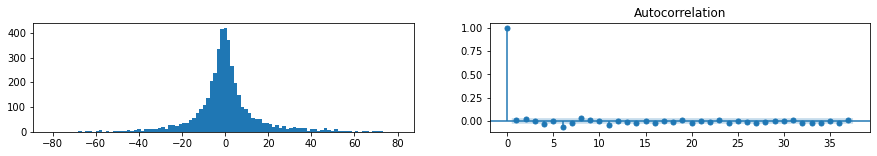

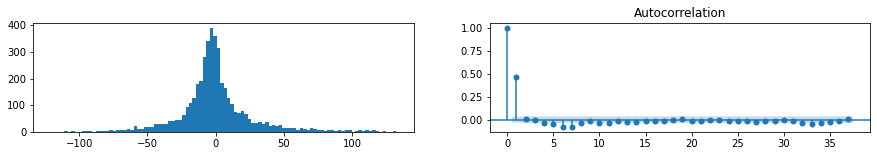

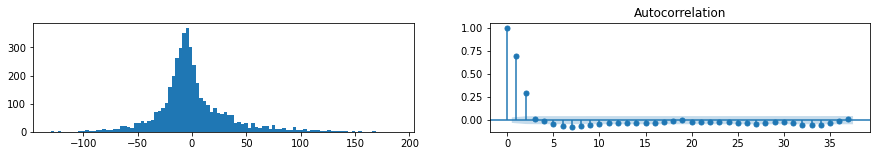

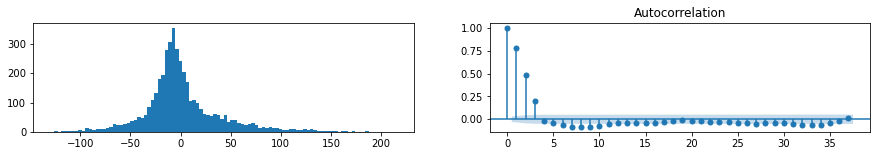

In [30]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices[targetSeries] = testY[:,i]
    Prices['Prediction'] = pred[:,i]
            
            

            
    from scipy import stats
    from statsmodels.graphics.tsaplots import plot_acf
    
    res = (Prices[targetSeries] - Prices['Prediction']).to_numpy()
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 2) )

    ax[0].hist( res, bins = 100 )    
    plot_acf( res, ax=ax[1] )       

## Visualization

[INFO] Feature:  CO
------------------------------------------------


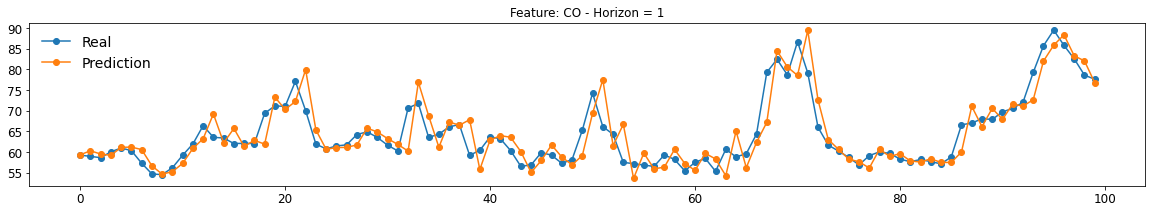

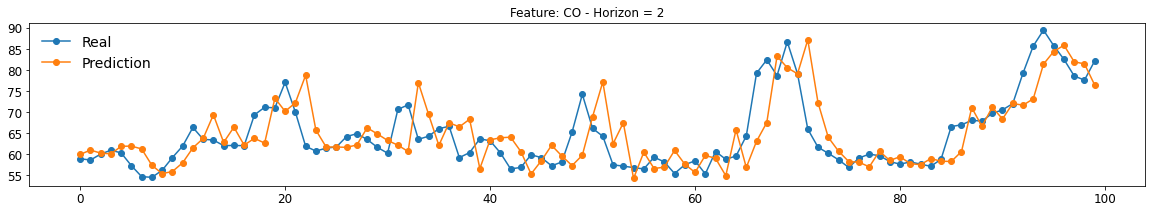

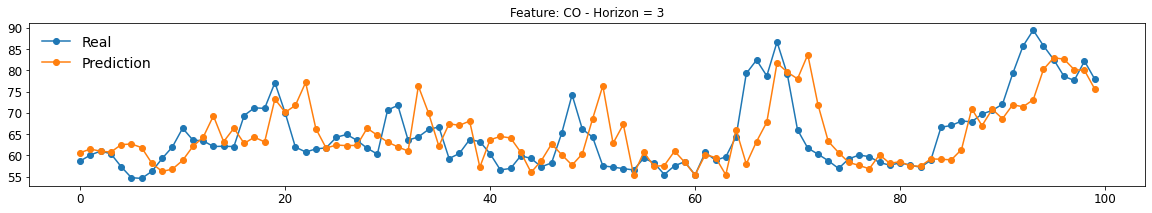

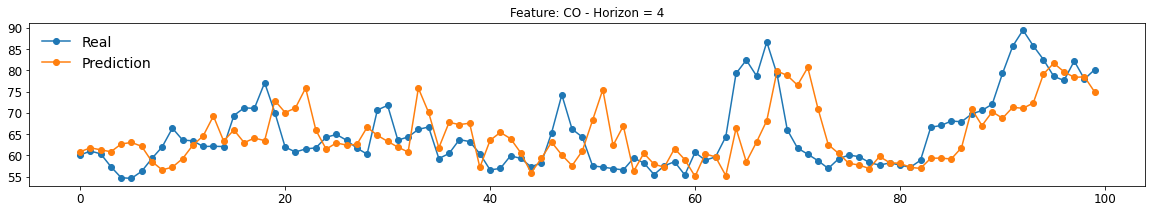

In [31]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = scaler.inverse_transform( testY[:,  i] )
    Prices['Prediction'] = scaler.inverse_transform( pred[:, i]   )


            
            
    # Plot Real & Predicted values
    #
    Prices[:100].plot( figsize = (20, 3), marker = 'o' )
    #
    plt.title('Feature: {} - Horizon = {}'.format(targetSeries, i+1))
    plt.legend( frameon = False, fontsize = 14)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.show()        

## Examples

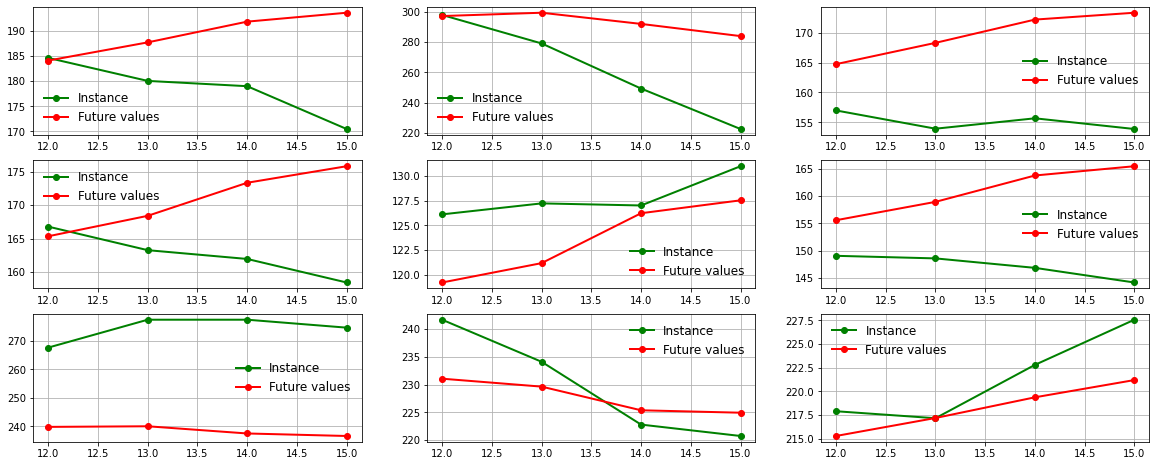

In [32]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 8) )
# RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 9)]
RandomInstances = [913, 205, 2254, 2007, 1829, 1144, 840, 713, 3457]
for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    plt.grid()
#     plot_scatter(range(0, Lag),             testX[i,:Lag], color='b')
    plt.plot(range(Lag, Lag + Horizon), testY[i], color='g', marker = 'o', linewidth = 2)
    plt.plot(range(Lag, Lag + Horizon), pred[i],  color='r', marker = 'o', linewidth = 2)

    plt.legend(['Instance', 'Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()

# Store predictions

In [33]:
Outputs = pd.DataFrame([])
#
#
Outputs[targetSeries] = testY.flatten()
Outputs['NBeats']     = pred.flatten()
#
Outputs.to_csv('Predictions/NBeats.csv')